In [492]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


# from imblearn.over_sampling import SMOTENC
# from imblearn.over_sampling import SMOTE

sns.set(style="ticks", color_codes=True)


# magic word for producing visualizations in notebook
%matplotlib inline

In [493]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The following meanings are equivalent of NaN (by looking at DIAS Attributes - Values 2017.xlsx)- 
1. The value of -1, represents an unknown value
2. For a few other attrbutes a value of 0 or 9 or 10 is used to represent an unknow value... we'll takle this later


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [494]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [495]:
print(mailout_train.shape)
print((mailout_train.RESPONSE.sum())*100/len(mailout_train))

(42962, 367)
1.2383036171500397


# Data Exploration and Cleaning


In [496]:
# To start with, we will consider only those columns that are part of the data dictionary.

In [497]:
df_attrs = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
df_values = df_attrs.copy()
df_attrs.drop(columns=df_attrs.columns[0], inplace=True)
df_attrs.dropna(inplace=True)
df_attrs = df_attrs.reset_index(drop=True)


df_values.drop(columns=df_values.columns[0], inplace=True)
df_values.Attribute = df_values.Attribute.fillna(method='ffill')
print(df_values.shape)
print(df_values.head())

print(df_attrs.shape)
df_attrs.head()

(2258, 5)
  Attribute         Description Value                     Meaning      Type
0  AGER_TYP  best-ager typology    -1                     unknown  Category
1  AGER_TYP                 NaN     0  no classification possible       NaN
2  AGER_TYP                 NaN     1             passive elderly       NaN
3  AGER_TYP                 NaN     2            cultural elderly       NaN
4  AGER_TYP                 NaN     3   experience-driven elderly       NaN
(314, 5)


,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,-1,unknown,Category
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Category
2,ALTER_HH,main age within the household,0,unknown / no main age detectable,Numerical
3,ANREDE_KZ,gender,"-1, 0",unknown,Category
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),Numerical


In [498]:
# let's look at the columns in the mailout that are not part of the attribute values table
common_columns = (set(list(df_attrs.Attribute)) & set(list(mailout_train.columns)))
extra_columns = set(list(mailout_train.columns)) - set(list(df_attrs.Attribute))
print(extra_columns)
print(len(extra_columns))

{'D19_VERSICHERUNGEN', 'UMFELD_JUNG', 'RT_UEBERGROESSE', 'D19_BANKEN_GROSS', 'D19_KINDERARTIKEL', 'EINGEZOGENAM_HH_JAHR', 'D19_VERSI_OFFLINE_DATUM', 'CJT_TYP_6', 'ALTERSKATEGORIE_FEIN', 'D19_TELKO_MOBILE', 'D19_TECHNIK', 'D19_WEIN_FEINKOST', 'ALTER_KIND3', 'ALTER_KIND4', 'RESPONSE', 'RT_KEIN_ANREIZ', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_KONSUMTYP_MAX', 'KONSUMZELLE', 'DSL_FLAG', 'D19_ENERGIE', 'D19_RATGEBER', 'VK_DISTANZ', 'SOHO_KZ', 'KBA13_CCM_1401_2500', 'KBA13_HHZ', 'D19_REISEN', 'D19_SOZIALES', 'D19_SAMMELARTIKEL', 'D19_TIERARTIKEL', 'D19_LEBENSMITTEL', 'D19_BILDUNG', 'D19_KOSMETIK', 'D19_VERSAND_REST', 'HH_DELTA_FLAG', 'EINGEFUEGT_AM', 'VHA', 'EXTSEL992', 'KBA13_ANTG4', 'KBA13_GBZ', 'D19_BANKEN_LOKAL', 'D19_TELKO_REST', 'UNGLEICHENN_FLAG', 'D19_BANKEN_DIREKT', 'VERDICHTUNGSRAUM', 'ARBEIT', 'D19_BEKLEIDUNG_REST', 'CJT_TYP_3', 'D19_VERSI_ONLINE_DATUM', 'D19_FREIZEIT', 'AKT_DAT_KL', 'LNR', 'CJT_TYP_1', 'D19_DIGIT_SERV', 'KBA13_BAUMAX', 'D19_BIO_OEKO', 'D19_DROGERIEARTIKEL', 'KK_KUNDENT

#### the following are the observations. This had to be done manually
D19_WEIN_FEINKOST - present as D19_WEIN_FEINKOST_RZ in the data dictionary  
AKT_DAT_KL - is not present  
D19_SOZIALES - not present  
RT_SCHNAEPPCHEN - not present  
ANZ_STATISTISCHE_HAUSHALTE -  not present  
D19_VOLLSORTIMENT - present as D19_VOLLSORTIMENT_RZ  
HH_DELTA_FLAG  
D19_KOSMETIK - D19_KOSMETIK_RZ  
D19_BANKEN_REST - D19_BANKEN_REST_RZ  
FIRMENDICHTE  
KBA13_ANTG1 -   
D19_SCHUHE - D19_SCHUHE_RZ  

Looks like many of the columns that seem missing are actually present in the data dictionary suffixed with _RZ.
Let's do a quick check of all the columns in the data dictionary whose first letters match the column of the mailout_train

In [499]:
mailout_columns = mailout_train.columns
matched_columns = dict()
for acolname in extra_columns:
    if (df_attrs[df_attrs.Attribute.str.contains(acolname)].shape[0] > 0):
        matched_value = df_attrs[df_attrs.Attribute.str.contains(acolname)].Attribute.values[0]
#         print('{} in attr matched {} in the mailout'.format(acolname, ))
        matched_columns[acolname] =  matched_value
#     else:
#         print('no matching column {} found in the data dictionary table'.format(acolname))


In [500]:
len(matched_columns)
matched_columns.keys()

dict_keys(['D19_VERSICHERUNGEN', 'D19_BANKEN_GROSS', 'D19_KINDERARTIKEL', 'D19_TELKO_MOBILE', 'D19_TECHNIK', 'D19_WEIN_FEINKOST', 'D19_ENERGIE', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_TIERARTIKEL', 'D19_LEBENSMITTEL', 'D19_BILDUNG', 'D19_KOSMETIK', 'D19_VERSAND_REST', 'D19_BANKEN_LOKAL', 'D19_TELKO_REST', 'D19_BANKEN_DIREKT', 'D19_BEKLEIDUNG_REST', 'D19_FREIZEIT', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_DROGERIEARTIKEL', 'KK_KUNDENTYP', 'D19_LOTTO', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_SONSTIGE', 'D19_SCHUHE', 'D19_NAHRUNGSERGAENZUNG', 'D19_HANDWERK', 'D19_GARTEN', 'D19_VOLLSORTIMENT', 'D19_HAUS_DEKO'])

In [501]:
common_columns = list(common_columns) + list(matched_columns.keys())
common_columns

['KBA13_BMW',
 'KBA05_HERST4',
 'KBA13_HERST_EUROPA',
 'D19_GESAMT_OFFLINE_DATUM',
 'KBA05_MAXVORB',
 'KBA05_ANTG1',
 'SEMIO_FAM',
 'KBA13_FAB_ASIEN',
 'KBA13_KW_120',
 'ALTER_HH',
 'D19_GESAMT_ONLINE_DATUM',
 'FINANZTYP',
 'KBA13_BJ_2000',
 'KBA05_ALTER3',
 'D19_TELKO_ANZ_12',
 'KBA13_HERST_ASIEN',
 'KBA13_ANZAHL_PKW',
 'ANREDE_KZ',
 'KBA13_SEG_KLEINWAGEN',
 'KBA13_KRSSEG_VAN',
 'REGIOTYP',
 'PLZ8_ANTG2',
 'D19_VERSI_ANZ_12',
 'KBA05_HERST3',
 'KBA13_KRSZUL_NEU',
 'KBA13_RENAULT',
 'KBA13_KMH_211',
 'KBA13_VW',
 'D19_BANKEN_ANZ_24',
 'KBA13_SEG_SONSTIGE',
 'KBA05_CCM1',
 'KBA13_NISSAN',
 'KBA13_SITZE_5',
 'D19_VERSI_ANZ_24',
 'KBA05_KW2',
 'D19_VERSAND_ANZ_24',
 'KBA13_KW_121',
 'KBA05_MAXSEG',
 'D19_VERSAND_DATUM',
 'KBA05_ANHANG',
 'LP_FAMILIE_GROB',
 'CAMEO_DEU_2015',
 'KBA05_ZUL3',
 'KBA05_ALTER4',
 'SEMIO_REL',
 'KBA13_KMH_0_140',
 'KBA05_SEG2',
 'KBA05_ANTG2',
 'KBA13_SEG_VAN',
 'KBA13_HALTER_45',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'KBA13_TOYOTA',
 'KBA13_SITZE_4',
 'KBA05_ZUL1',
 

In [502]:
def mark_invalid_values_as_null(df):
    print('Starting cleanup')
    df = df.copy()
    categorical_dict = {}
    columns_with_unknown_values = ''
    for colname in common_columns:
#         Sometimes the colname in the attr DF is a a bit diff
        if colname in matched_columns.keys():
            acolname = matched_columns[colname]
        else:
            acolname = colname
        
        
#         print('{} - {}'.format(colname, df_attrs[df_attrs.Attribute==colname].Type.values[0]))
        valid_values = df_values[(df_values.Attribute==acolname) & \
                                 ((df_values.Meaning.str.contains('unknown')==False) \
                                 | df_values.Meaning.isnull())].Value.values
    
        if ('X' in df[colname].unique()) or ('XX' in df[colname].unique()):
            print('unique values for column:{}, are {}'.format(colname, df[colname].unique()))
            
        if (df_attrs[df_attrs.Attribute==acolname].Value.values[0] == '…'): # continuous variable
            print('{} is a continuous feature'.format(colname))
        else:
            if df_attrs[df_attrs.Attribute==acolname].Meaning.values[0].find('unknown') > -1:
                unknown_values = str(df_attrs[df_attrs.Attribute==acolname].Value.values[0])
                print('unknown values for {} are {}'.format(colname, unknown_values))
                
            m = df[colname].isin(valid_values)
            df[colname] = df[colname].where(m, other=np.nan)
            if (len(m) -sum(m)) > 0:
                columns_with_unknown_values += "'" + colname + "'" + ','
            print('nulls + unknowns = {}'.format(len(m) -sum(m)))
        print('-----------------------------------')
    return df, categorical_dict, columns_with_unknown_values

In [503]:
set(common_columns) - set(list(mailout_train.columns))

set()

In [504]:
mailout_train1, _, _ = mark_invalid_values_as_null(mailout_train[common_columns])
mailout_train1['RESPONSE'] = mailout_train.RESPONSE
mailout_train1.shape

Starting cleanup
unknown values for KBA13_BMW are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for KBA05_HERST4 are -1, 9
nulls + unknowns = 9031
-----------------------------------
unknown values for KBA13_HERST_EUROPA are -1
nulls + unknowns = 7962
-----------------------------------
nulls + unknowns = 0
-----------------------------------
unknown values for KBA05_MAXVORB are -1, 9
nulls + unknowns = 9031
-----------------------------------
unknown values for KBA05_ANTG1 are -1


/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


nulls + unknowns = 8648
-----------------------------------
unknown values for SEMIO_FAM are -1, 9
nulls + unknowns = 0
-----------------------------------
unknown values for KBA13_FAB_ASIEN are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for KBA13_KW_120 are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for ALTER_HH are 0
nulls + unknowns = 13177
-----------------------------------
nulls + unknowns = 0
-----------------------------------
unknown values for FINANZTYP are -1
nulls + unknowns = 0
-----------------------------------
unknown values for KBA13_BJ_2000 are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for KBA05_ALTER3 are -1, 9
nulls + unknowns = 9031
-----------------------------------
nulls + unknowns = 0
-----------------------------------
unknown values for KBA13_HERST_ASIEN are -1
nulls + unknowns = 7962
-----------------------------------
KBA13_ANZAHL_PKW is a continuous fe

unknown values for KBA05_MODTEMP are -1, 9
nulls + unknowns = 8065
-----------------------------------
unknown values for KBA05_SEG10 are -1, 9
nulls + unknowns = 9031
-----------------------------------
nulls + unknowns = 0
-----------------------------------
unknown values for KBA13_KMH_140 are -1
nulls + unknowns = 7962
-----------------------------------
nulls + unknowns = 6997
-----------------------------------
unknown values for KBA05_SEG4 are -1, 9
nulls + unknowns = 9031
-----------------------------------
unknown values for KKK are -1, 0
nulls + unknowns = 9930
-----------------------------------
unknown values for KBA13_HALTER_30 are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for KBA05_KRSOBER are -1, 9
nulls + unknowns = 9031
-----------------------------------
unknown values for FINANZ_UNAUFFAELLIGER are -1
nulls + unknowns = 0
-----------------------------------
unknown values for SHOPPER_TYP are -1
nulls + unknowns = 7397
--------------

nulls + unknowns = 0
-----------------------------------
unknown values for PLZ8_GBZ are -1
nulls + unknowns = 8153
-----------------------------------
unknown values for WOHNLAGE are -1
nulls + unknowns = 7777
-----------------------------------
unknown values for KBA13_KMH_251 are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for KBA05_MOD2 are -1, 9
nulls + unknowns = 9031
-----------------------------------
unknown values for KBA13_CCM_1800 are -1
nulls + unknowns = 7962
-----------------------------------
nulls + unknowns = 605
-----------------------------------
nulls + unknowns = 7777
-----------------------------------
unknown values for KBA13_ALTERHALTER_30 are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for KBA13_SEG_OBERKLASSE are -1
nulls + unknowns = 7962
-----------------------------------
unknown values for FINANZ_ANLEGER are -1
nulls + unknowns = 0
-----------------------------------
unknown values for KB

nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
-----------------------------------
nulls + unknowns = 0
----------

(42962, 307)

In [505]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Pe\rcentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()


def get_null_counts(df):
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/df.shape[0], 2)}
    df_nulls = pd.DataFrame(data=dict, index=null_data.index)
    return df_nulls

/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


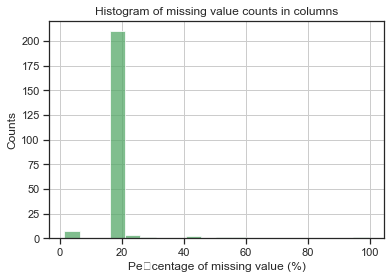

                 nulls    pct
ALTER_HH         13177  30.67
KBA05_BAUMAX     22980  53.49
CAMEO_DEUG_2015  17915  41.70
TITEL_KZ         42749  99.50
AGER_TYP         17963  41.81
KK_KUNDENTYP     25316  58.93


In [506]:
# let's get an idea about how many nulls per column is present
mailout_nulls = get_null_counts(mailout_train1)
plot_hist_missing_col(mailout_nulls)
# mailout_nulls.sort_values(by=['pct'], axis=0, kind='quicksort', ascending=False)
# mailout_nulls
print(mailout_nulls[mailout_nulls.pct > 25])

In [507]:
# there's a significant number of columns with more than 10% of the values as null. 
# For now, let's drop columns that have more than 30% of their values as null
print(mailout_nulls[mailout_nulls.pct>25].index)
print(mailout_train1.shape)
mailout_train1 = mailout_train1.drop(columns=mailout_nulls[mailout_nulls.pct>25].index)
print(mailout_train1.shape)
del mailout_nulls

Index(['ALTER_HH', 'KBA05_BAUMAX', 'CAMEO_DEUG_2015', 'TITEL_KZ', 'AGER_TYP',
       'KK_KUNDENTYP'],
      dtype='object')
(42962, 307)
(42962, 301)


In [508]:
mailout_train1[mailout_train1.KBA05_HERST1.isnull() & mailout_train1.RESPONSE==1][['RESPONSE','KBA05_HERST1']].head()

,RESPONSE,KBA05_HERST1
595,1,NaN
705,1,NaN
810,1,NaN
1402,1,NaN
2403,1,NaN


In [509]:
# there are a few featuress where "no known transactions" does not seem to be in the proper sequence
# These probably should be replaced with the right sequence value:
# First we need to understand, if a statememt like "no transactions known" means that the data is unknown and 
# hence a Nan OR does it mean 0 transactions?
# TBD:  Need to handle this case maybe in the 2nd version
re_sequence = { \
 'D19_BANKEN_DIREKT_RZ': (0,8),   \
 'D19_BANKEN_GROSS_RZ': (0,8), \
 'D19_BANKEN_LOKAL_RZ': (0,8), \
 'D19_BANKEN_REST_RZ': (0,8), \
 'D19_BEKLEIDUNG_GEH_RZ': (0,8), \
 'D19_BEKLEIDUNG_REST_RZ': (), \
 'D19_BILDUNG_RZ': (), \
 '': ()
}


In [510]:
# When looking at the data dictionary, the following are some obervations:
# There seem to be 2 sets of datapoints about the share of car owners in PLZ8
# Columns: KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61 ->
#        Can be removed sonce other columns are describing similar features
# Let's delete these columns
cols = 'KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61'.split(',')
mailout_train1.drop(columns= cols, inplace=True)

In [511]:
# These features seem to be related:
cols = 'FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER'.split(',')
# it seems that "FINANZTYP" wraps up the info in the other columns above and hence they can be dropped
mailout_train1.drop(columns=cols, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a27b2e850>,
      dtype=object)

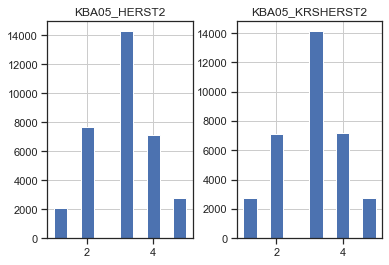

In [512]:
# also these:
cols = 'KBA05_KRSHERST2,KBA05_HERST2'.split(',')
mailout_train1[cols].hist()

In [513]:
# the following cols contain info already contained by other columns and hence let's drop them
cols = 'KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3'.split(',')
mailout_train1.drop(columns = cols, inplace=True)

In [514]:
# the column CAMEO_DEUG_2015 seems good enough CAMEO classification.. Let's drop the other 2 which do similar thing:
cols = 'CAMEO_DEU_2015'.split(',')
mailout_train1.drop(columns= cols, inplace=True)
mailout_train1.shape

(42962, 287)

In [515]:
# We allready have the GEBURTSJAHR col and hence do not need the ALTERSKATEGORIE_GROB column
mailout_train1.drop(columns='ALTERSKATEGORIE_GROB', inplace=True)

In [516]:
mailout_train1['GEBURTSJAHR'] = 2020 - mailout_train1.GEBURTSJAHR

In [517]:
# are these complimentary to each other
cols = 'LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB'.split(',')
mailout_train1[cols].head(10)

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB
0,8.0,2.0
1,19.0,5.0
2,NaN,NaN
3,16.0,4.0
4,9.0,3.0
5,6.0,2.0
6,13.0,3.0
7,19.0,5.0
8,NaN,NaN
9,NaN,NaN


In [518]:
# it seems that the lifestage fine & rough are co-related.. the same goes with familly fine and roughstage... 
# hence one column each can be dropped.. let's drop the less granular one for now
cols = 'LP_STATUS_GROB,LP_FAMILIE_GROB'.split(',')
mailout_train1.drop(columns=cols, inplace=True)
mailout_train1.shape

(42962, 284)

In [519]:
mailout_train1.drop(columns='LP_LEBENSPHASE_GROB', inplace=True)

In [520]:
# the following colls also contain duplicate info and can be dropped
cols = 'KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4'.split(',')
mailout_train1.drop(columns=cols, inplace=True)
mailout_train1.shape

(42962, 279)

In [521]:
# Now let's look at highly correlated features and see if we can drop them
# Create correlation matrix
corr_matrix = mailout_train1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [522]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

['KBA13_SITZE_4',
 'KBA13_KMH_250',
 'D19_VERSAND_OFFLINE_DATUM',
 'KBA13_HERST_AUDI_VW',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_ANZ_12',
 'KBA05_KRSZUL',
 'D19_GESAMT_DATUM',
 'KBA13_FAB_SONSTIGE',
 'LP_FAMILIE_FEIN']

In [523]:
# let's do an analysis of how many highly correlated features are there
for col in mailout_train1.columns: # first 5 columns
    if col not in ['OST_WEST_KZ','CAMEO_DEUG_2015']:
        col_cor = corr_matrix[col]
        relevant_features = col_cor[col_cor > .88]
        if relevant_features.count()>1:
            print(relevant_features)
            print('----------------------')

D19_GESAMT_OFFLINE_DATUM     1.000000
D19_VERSAND_OFFLINE_DATUM    0.911387
Name: D19_GESAMT_OFFLINE_DATUM, dtype: float64
----------------------
D19_GESAMT_ONLINE_DATUM     1.000000
D19_VERSAND_ONLINE_DATUM    0.939375
Name: D19_GESAMT_ONLINE_DATUM, dtype: float64
----------------------
KBA13_KMH_211    1.000000
KBA13_KMH_250    0.964029
Name: KBA13_KMH_211, dtype: float64
----------------------
D19_VERSAND_ANZ_24    1.000000
D19_VERSAND_ANZ_12    0.910406
D19_GESAMT_ANZ_24     0.939647
Name: D19_VERSAND_ANZ_24, dtype: float64
----------------------
D19_VERSAND_DATUM    1.000000
D19_GESAMT_DATUM     0.884059
Name: D19_VERSAND_DATUM, dtype: float64
----------------------
D19_GESAMT_ONLINE_QUOTE_12     1.000000
D19_VERSAND_ONLINE_QUOTE_12    0.912317
Name: D19_GESAMT_ONLINE_QUOTE_12, dtype: float64
----------------------
LP_LEBENSPHASE_FEIN    1.000000
LP_FAMILIE_FEIN        0.951198
Name: LP_LEBENSPHASE_FEIN, dtype: float64
----------------------
KBA13_KMH_211    0.964029
KBA13_KMH_250

##### observations on the correlation of the 1st 50 features
1. "KBA13_KMH_140" & "KBA13_KMH_0_140" are highly co-related. When looking at their meaning in the data dictionary, it seems that "KBA13_KMH_0_140" value is already part of the previous column and hence can be dropped.
2. "KBA13_HERST_SONST" and "KBA13_FAB_SONSTIGE" have perfect correlation and hence one of them can be dropped. Even their meanings look pretty similar.
3. It seems that the info contained in "D19_GESAMT_DATUM" is already part of info in multuple diff. features, and can probably be dropped..
4. Although "LP_FAMILIE_FEIN" and "LP_LEBENSPHASE_FEIN" seem to represent different meaning as per the data dictionary, they have a very high correlation and hence one of them can be considered for being dropped.
5. "D19_VERSAND_ANZ_24" and "D19_VERSAND_ANZ_12" are highly correlated and the former seems to contain the info in the later. Hence let's drop the later column.
6. "KBA13_KMH_211" iss higly correlated with "KBA13_KMH_250" and already contains the info in it. Hence "KBA13_KMH_250" can be dropped.

In [524]:
# Let's drop the columns indentified as highly correlated above so far and do anaother round of analysis
cols = 'KBA13_KMH_0_140,KBA13_HERST_SONST,D19_GESAMT_DATUM,LP_FAMILIE_FEIN,D19_VERSAND_ANZ_12,KBA13_KMH_250'.split(',')
mailout_train1.drop(columns=cols, inplace=True)
mailout_train1.shape

(42962, 273)

In [525]:
# # Let's replace all X and XX with NaN
mailout_train1 = mailout_train1.replace('X', np.nan)
mailout_train1 = mailout_train1.replace('XX', np.nan)

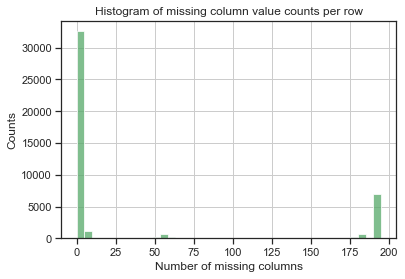

In [526]:
null_row_counts = mailout_train1.isnull().sum(axis=1)
null_row_counts.values

plt.hist(null_row_counts.values, bins=40, facecolor='g', alpha=0.75)

plt.xlabel('Number of missing columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of missing column value counts per row', fontsize=12)
plt.grid(True)
plt.show()

In [527]:
# there are significant number of rows that have more than 100 columns having null values in them.
# Let's delete these rows, as otherwise filling them all up with some value is likely to bias the result
print(mailout_train1.shape)
print(mailout_train1.RESPONSE.sum())
print(mailout_train1.dropna(thresh=len(mailout_train1.columns)-40).shape)
print(mailout_train1.dropna(thresh=len(mailout_train1.columns)-40).RESPONSE.sum())
# mailout_train1 = mailout_train1.dropna(thresh=len(mailout_train1.columns)-40)
# mailout_train1.reset_index(drop=True, inplace=True)

(42962, 273)
532
(33837, 273)
416


In [528]:
# among the rows that contain more than 100 cols as null... 
# let's see in those rows which columns contain more than 75% nulls
# mailout_train1.iloc[null_row_counts].head()
df_row_nulls = pd.DataFrame( null_row_counts, columns=['null_row_cnt'])
df_row_nulls.head(10)
df_null_rows = mailout_train1.copy()
df_null_rows['null_row_cnt'] = df_row_nulls.null_row_cnt
df_null_rows.null_row_cnt.head(5)

0    0
1    0
2    3
3    0
4    0
Name: null_row_cnt, dtype: int64

/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


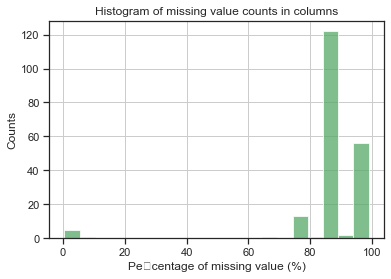

                             nulls    pct
KBA13_BMW                     7962  87.25
KBA05_HERST4                  9031  98.97
KBA13_HERST_EUROPA            7962  87.25
KBA05_MAXVORB                 9031  98.97
KBA05_ANTG1                   8648  94.77
KBA13_FAB_ASIEN               7962  87.25
KBA13_KW_120                  7962  87.25
KBA13_BJ_2000                 7962  87.25
KBA13_HERST_ASIEN             7962  87.25
KBA13_ANZAHL_PKW              7962  87.25
KBA13_SEG_KLEINWAGEN          7962  87.25
KBA13_KRSSEG_VAN              7962  87.25
REGIOTYP                      8300  90.96
PLZ8_ANTG2                    8093  88.69
KBA05_HERST3                  9031  98.97
KBA13_KRSZUL_NEU              7962  87.25
KBA13_RENAULT                 7962  87.25
KBA13_KMH_211                 7962  87.25
KBA13_VW                      7962  87.25
KBA13_SEG_SONSTIGE            7962  87.25
KBA05_CCM1                    9031  98.97
KBA13_NISSAN                  7962  87.25
KBA13_SITZE_5                 7962

In [529]:
df_null_rows = df_null_rows[df_null_rows.null_row_cnt > 40]
mailout_nulls = get_null_counts(df_null_rows)
plot_hist_missing_col(mailout_nulls)
# mailout_nulls.sort_values(by=['pct'], axis=0, kind='quicksort', ascending=False)
# mailout_nulls
print(mailout_nulls[mailout_nulls.pct > 20])

In [530]:
# let's drop all the columns above, 
# since they do not contribute to detecting a significant number of positive ressponses
# mailout_train1 = mailout_train1.drop(columns=mailout_nulls[mailout_nulls.pct>70].index)
# print(mailout_train1.shape)
# print(mailout_train1.RESPONSE.sum())
# mailout_train1.head()

In [531]:
from sklearn.impute import SimpleImputer

# start preparing the data for model building



In [532]:
# fit and transform an imputer
mailout_train1.reset_index(drop=True, inplace=True)
imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
imputed_data = imputer.fit_transform(mailout_train1)
mailout_train1 = pd.DataFrame(imputed_data, columns=mailout_train1.columns)

In [533]:
# # binary encode binary alphanumric columns
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
binary_columns = list(set('OST_WEST_KZ,ANREDE_KZ,BIP_FLAG,SOHO_FLAG'.split(',')).intersection(set(mailout_train1.columns)))

mailout_train1['OST_WEST_KZ'] = lb.fit_transform(mailout_train1['OST_WEST_KZ'])

In [534]:
mailout_train1['ANREDE_KZ'] = lb.fit_transform(mailout_train1['ANREDE_KZ'].astype(int))
mailout_train1[binary_columns].head()

,OST_WEST_KZ,ANREDE_KZ
0,1,1
1,1,1
2,0,0
3,1,1
4,1,0


In [535]:
category_columns = 'AGER_TYP,CAMEO_DEU_2015,CAMEO_DEUINTL_2015,CJT_GESAMTTYP,FINANZTYP,' + \
                    'GEBAEUDETYP,GFK_URLAUBERTYP,HAUSHALTSSTRUKTUR,HEALTH_TYP,' + \
                    'KBA05_MAXHERST,LP_FAMILIE_FEIN,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,' + \
                    'NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,SHOPPER_TYP,TITEL_KZ'
category_columns = category_columns.split(',')
category_columns = list(set(category_columns).intersection(set(mailout_train1.columns)))

In [536]:
category_columns

['HEALTH_TYP',
 'NATIONALITAET_KZ',
 'CJT_GESAMTTYP',
 'SHOPPER_TYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'LP_LEBENSPHASE_FEIN',
 'FINANZTYP',
 'KBA05_MAXHERST',
 'PRAEGENDE_JUGENDJAHRE']

In [537]:
# dummy encode non binary categorical columns
mailout_train2 = pd.get_dummies(mailout_train1, columns = category_columns)
mailout_train2.head()

,KBA13_BMW,KBA05_HERST4,KBA13_HERST_EUROPA,D19_GESAMT_OFFLINE_DATUM,KBA05_MAXVORB,KBA05_ANTG1,SEMIO_FAM,KBA13_FAB_ASIEN,KBA13_KW_120,D19_GESAMT_ONLINE_DATUM,KBA13_BJ_2000,D19_TELKO_ANZ_12,KBA13_HERST_ASIEN,KBA13_ANZAHL_PKW,ANREDE_KZ,KBA13_SEG_KLEINWAGEN,KBA13_KRSSEG_VAN,REGIOTYP,PLZ8_ANTG2,D19_VERSI_ANZ_12,KBA05_HERST3,KBA13_KRSZUL_NEU,KBA13_RENAULT,KBA13_KMH_211,KBA13_VW,D19_BANKEN_ANZ_24,KBA13_SEG_SONSTIGE,KBA05_CCM1,KBA13_NISSAN,KBA13_SITZE_5,D19_VERSI_ANZ_24,KBA05_KW2,D19_VERSAND_ANZ_24,KBA13_KW_121,KBA05_MAXSEG,D19_VERSAND_DATUM,KBA05_ANHANG,KBA05_ZUL3,SEMIO_REL,KBA05_SEG2,KBA05_ANTG2,KBA13_SEG_VAN,KBA13_HALTER_45,D19_GESAMT_ONLINE_QUOTE_12,KBA13_TOYOTA,KBA13_SITZE_4,KBA05_ZUL1,KBA13_SEG_SPORTWAGEN,ONLINE_AFFINITAET,KBA13_SEG_MINIWAGEN,ANZ_HH_TITEL,KBA05_HERST5,KBA13_KMH_180,KBA13_BJ_2006,KBA13_HERST_BMW_BENZ,KBA13_CCM_3000,ANZ_TITEL,KBA05_SEG3,KBA13_SEG_MINIVANS,KBA13_MOTOR,KBA05_CCM2,KBA05_MOD1,KBA05_SEG1,KBA13_SITZE_6,KBA13_HALTER_20,KBA13_HALTER_65,KBA13_KW_90,KBA13_CCM_1600,INNENSTADT,KBA13_HALTER_60,KBA13_CCM_3001,KBA13_PEUGEOT,KBA13_KW_60,KBA13_KRSHERST_FORD_OPEL,PLZ8_ANTG3,BALLRAUM,SEMIO_VERT,ANZ_HAUSHALTE_AKTIV,KBA13_SEG_GROSSRAUMVANS,KBA05_MOD3,KBA05_MODTEMP,KBA05_SEG10,D19_BANKEN_DATUM,KBA13_KMH_140,KONSUMNAEHE,KBA05_SEG4,KKK,KBA13_HALTER_30,KBA05_KRSOBER,KBA05_VORB2,KBA13_CCM_2501,KBA05_HERST2,KBA13_OPEL,D19_VERSAND_OFFLINE_DATUM,KBA13_KW_30,KBA05_ANTG4,KBA13_VORB_0,KBA13_KMH_110,KBA13_SEG_UTILITIES,D19_BANKEN_ONLINE_DATUM,KBA13_KW_0_60,KBA13_KW_80,SEMIO_RAT,VERS_TYP,ANZ_PERSONEN,KBA13_BJ_2009,KBA13_VORB_2,KBA13_KW_70,KBA13_AUDI,KBA13_HALTER_40,KBA05_CCM3,D19_KONSUMTYP,KBA05_KW3,KBA13_KRSHERST_BMW_BENZ,SEMIO_LUST,KBA13_BJ_2004,KBA05_VORB0,GREEN_AVANTGARDE,KBA13_HERST_AUDI_VW,KBA05_MOTOR,KBA13_CCM_1000,W_KEIT_KIND_HH,KBA13_KW_40,MOBI_REGIO,D19_TELKO_ANZ_24,KBA05_ZUL2,PLZ8_ANTG1,KBA13_SEG_GELAENDEWAGEN,KBA13_KRSHERST_AUDI_VW,KBA13_HALTER_25,KBA05_ZUL4,SEMIO_KRIT,SEMIO_MAT,KBA05_MOD8,KBA05_ANTG3,KBA13_MERCEDES,KBA05_MOD4,KBA05_VORB1,KBA05_HERST1,OST_WEST_KZ,KBA13_KW_50,KBA05_DIESEL,KBA13_SEG_WOHNMOBILE,LP_STATUS_FEIN,KBA13_VORB_3,EWDICHTE,KBA05_KRSAQUOT,KBA13_VORB_1,PLZ8_BAUMAX,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_2500,KBA05_HERSTTEMP,SEMIO_ERL,KBA13_HERST_FORD_OPEL,PLZ8_HHZ,KBA13_CCM_2000,D19_TELKO_DATUM,PLZ8_GBZ,WOHNLAGE,KBA13_KMH_251,KBA05_MOD2,KBA13_CCM_1800,GEBAEUDETYP_RASTER,KBA13_SEG_OBERKLASSE,KBA05_SEG6,SEMIO_TRADV,KBA05_FRAU,KBA13_BJ_1999,KBA13_HALTER_55,KBA13_MAZDA,SEMIO_SOZ,KBA05_SEG9,KBA05_KRSVAN,RETOURTYP_BK_S,KBA13_FORD,KBA13_AUTOQUOTE,D19_VERSAND_ONLINE_DATUM,KBA13_KRSSEG_KLEIN,D19_GESAMT_ANZ_24,D19_GESAMT_ANZ_12,ZABEOTYP,KBA05_GBZ,D19_TELKO_ONLINE_DATUM,D19_TELKO_OFFLINE_DATUM,SEMIO_KULT,KBA05_KRSZUL,KBA05_SEG8,WOHNDAUER_2008,KBA05_AUTOQUOT,KBA13_KRSSEG_OBER,D19_BANKEN_ANZ_12,KBA13_SEG_KLEINST,KBA13_FAB_SONSTIGE,KBA13_SEG_MITTELKLASSE,KBA05_MAXAH,KBA13_HALTER_35,KBA05_SEG5,SEMIO_DOM,KBA05_KW1,KBA05_SEG7,MIN_GEBAEUDEJAHR,KBA13_BJ_2008,GEBURTSJAHR,KBA05_KRSKLEIN,KBA13_CCM_0_1400,D19_BANKEN_ONLINE_QUOTE_12,KBA13_SEG_KOMPAKTKLASSE,D19_BANKEN_OFFLINE_DATUM,KBA13_HALTER_66,KBA05_MAXBJ,HH_EINKOMMEN_SCORE,PLZ8_ANTG4,KBA13_CCM_1200,KBA13_FIAT,KBA05_CCM4,SEMIO_PFLICHT,KBA13_VORB_1_2,KBA13_KW_61_120,SEMIO_KAEM,KBA13_SEG_OBEREMITTELKLASSE,ORTSGR_KLS9,KBA13_CCM_1400,KBA13_KW_110,KBA13_CCM_1500,RELAT_AB,KBA05_MOTRAD,KBA13_KMH_140_210,KBA13_HALTER_50,KBA13_KRSAQUOT,D19_VERSICHERUNGEN,D19_BANKEN_GROSS,D19_KINDERARTIKEL,D19_TELKO_MOBILE,D19_TECHNIK,D19_WEIN_FEINKOST,D19_ENERGIE,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_TIERARTIKEL,D19_LEBENSMITTEL,D19_BILDUNG,D19_KOSMETIK,D19_VERSAND_REST,D19_BANKEN_LOKAL,D19_TELKO_REST,D19_BANKEN_DIREKT,D19_BEKLEIDUNG_REST,D19_FREIZEIT,D19_DIGIT_SERV,D19_BIO_OEKO,D19_DROGERIEARTIKEL,D19_LOTTO,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_SONSTIGE,D19_SCHUHE,D19_NAHRUNGSERGAENZUNG,D19_HANDWERK,D19_GARTEN,D19_VOLLSORTIMENT,D19_HAUS_DEKO,RESPONSE,HEALTH_TYP_1.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP

In [538]:
mailout_train2.shape

(42962, 363)

In [539]:
# let's apply scaling to the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mailout_scaled = scaler.fit_transform(mailout_train2)
mailout_scaled = pd.DataFrame(mailout_scaled, columns= mailout_train2.columns)

In [540]:
mailout_scaled.shape

(42962, 363)

In [541]:
df_response = mailout_scaled['RESPONSE']
mailout_scaled = mailout_scaled.drop(columns='RESPONSE')


In [548]:
# # the following is now just meandering aimlessly
# corr_matrix = mailout_train1.corr().abs()
# for col in mailout_train1.columns: # first 5 columns
#     if col not in ['OST_WEST_KZ','CAMEO_DEUG_2015']:
#         col_cor = corr_matrix[col]
#         relevant_features = col_cor[col_cor > .85]
#         if relevant_features.count()>1:
#             print(relevant_features)
#             print('----------------------')

In [549]:
# let's do a detailed analysis of the features


In [550]:
from sklearn.decomposition import PCA

# let's create a reusable function to execute PCA on data to a stated n number of components
# because we'll need to experiment with different number of PCA components
def do_pca(data, n):
    pca = PCA(n_components=n, random_state=1)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

def plot_variance(pca):
    num_components=len(pca.explained_variance_ratio_)
    num_components = np.arange(num_components)
    ratios = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(ratios)
    ax.bar(num_components, ratios)
    ax.plot(num_components, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
   
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

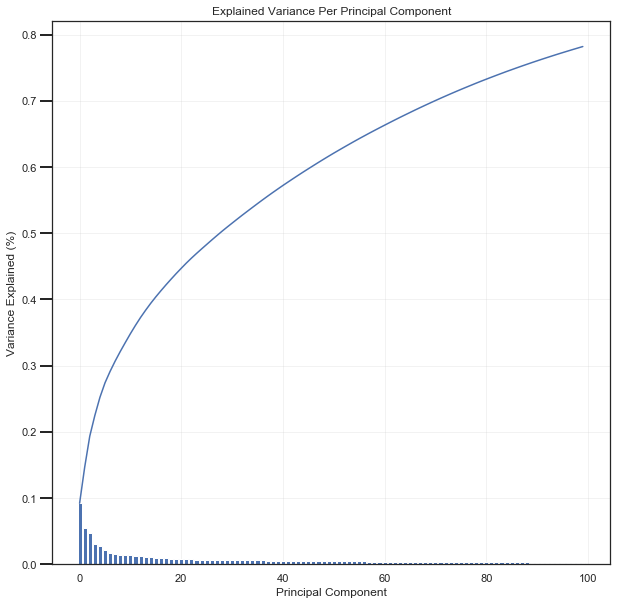

In [551]:
pca, X_pca = do_pca(mailout_scaled, 100)
plot_variance(pca)

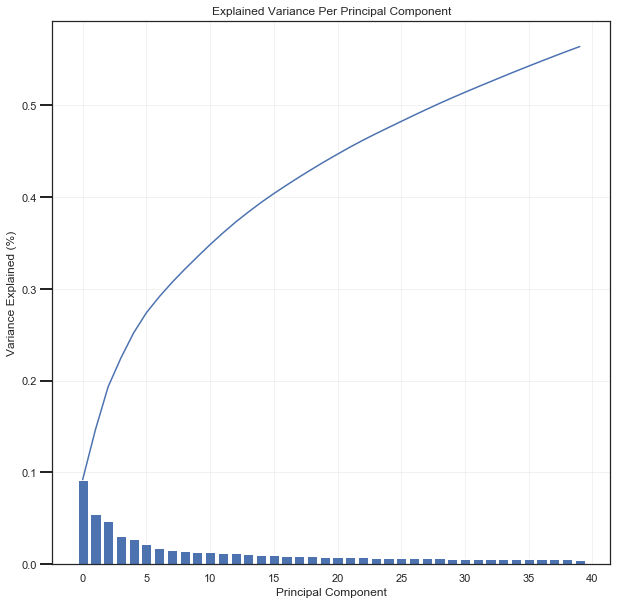

In [552]:
pca, X_pca = do_pca(mailout_scaled, 40)
plot_variance(pca)

In [553]:
import time
def show_confusion_matrix(classifier, X_test, y_test):
    class_names=['NO', 'YES']
    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
#                                      display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

def fit_classifier(clf, param_grid, X_train, Y_train, X_test, Y_test):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2, n_jobs=4)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X_train, Y_train)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    show_confusion_matrix(grid.best_estimator_, X_test, Y_test)
    
    print('--------------------------------')
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [554]:
X_train, X_test, y_train, y_test = train_test_split(mailout_scaled.astype(float), \
                                                    df_response, \
                                                    test_size=0.2, random_state=40)

Training GradientBoostingClassifier :
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.3min finished


GradientBoostingClassifier
Time taken : 117.99 secs
Best score : 0.5927
****************************************
Confusion matrix, without normalization
[[8484    7]
 [ 102    0]]
Normalized confusion matrix
[[9.99175598e-01 8.24402308e-04]
 [1.00000000e+00 0.00000000e+00]]


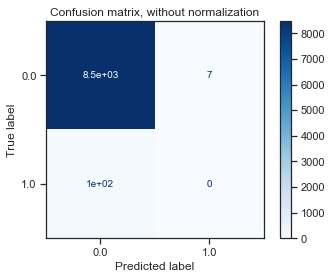

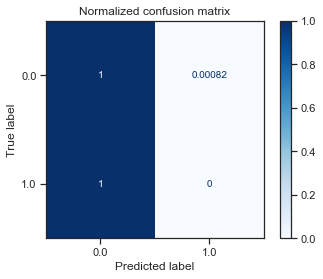

--------------------------------


(0.5927260802537361,
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 117.99)

In [573]:
# let's get a quick feel of predictability
grid_params = {
}

fit_classifier(GradientBoostingClassifier(), grid_params, X_train, y_train, X_test, y_test)

In [ ]:
# cls = GradientBoostingClassifier(n_estimators=500, random_state=42, verbose=3)
# cls.fit(X_train, y_train)
# show_confusion_matrix(cls, X_test, y_test)

In [570]:
# fit_classifier(RandomForestClassifier(), {}, X_train, y_train, X_test, y_test)

In [437]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pca.astype(float), \
                                                    df_response, \
                                                    test_size=0.33, random_state=40)

In [571]:
# fit_classifier(GaussianNB(), {}, X_train_p, y_train_p, X_test_p, y_test_p)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [409]:
# mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42833, 366)